In [59]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# House Requests and 311 Efficiency
In this notebook, we go on with the analysis by trying to detect which neighborhoods guarantee a more comfortable life, according to different factors that we'll step after step identify and describe.

## Implementation plan
* Extract relevant request categories from the main dataset;
* Time series analysis: period of the year, time of day, call duration, with clear comparison over the years (this is a key point of this analysis, to provide a measure of how much has the 311 efficiency improved/got worse over the years);
* Geolocation and maps: KNN / K-means clustering

### (I) Library imports

In [1]:
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
#import mpld3
%matplotlib inline

### (II) Load the dataset

In [3]:
# Load it into a Dataframe using pandas
path = '../data/311_filtered.csv'
df = pd.read_csv(path)
df.head()

,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Borough,Latitude,Longitude
0,11/07/2011 04:02:50 PM,11/07/2011 05:45:14 PM,NYPD,Blocked Driveway,No Access,Street/Sidewalk,BROOKLYN,40.609242,-73.982821
1,11/07/2011 11:53:37 AM,11/07/2011 03:14:40 PM,NYPD,Illegal Parking,Double Parked Blocking Traffic,Street/Sidewalk,BROOKLYN,40.692605,-73.997137
2,11/07/2011 05:53:47 PM,11/07/2011 06:13:21 PM,NYPD,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,MANHATTAN,40.762290,-73.986106
3,11/07/2011 07:47:15 PM,11/08/2011 12:13:05 AM,NYPD,Illegal Parking,Unauthorized Bus Layover,Street/Sidewalk,MANHATTAN,40.726866,-73.979908
4,11/07/2011 09:11:39 PM,11/08/2011 04:53:53 AM,DOT,Broken Muni Meter,No Receipt,Street,MANHATTAN,40.759064,-73.978450


We group by `Complaint Type` (which represents the category of the request) and sort by the most frequent complaint types:

In [183]:
# The 50 most frequent crimes
call_freq = df['Complaint Type'].groupby(df['Complaint Type']).count().sort_values(ascending=False).reset_index(name='count')

But there are many categories that have a very low count, therefore let's try to filter them out by picking those complaint types with high frequency (>= 10000):

In [31]:
call_freq[call_freq['count']>=10000].head()

,Complaint Type,count
0,Noise - Residential,921443
1,HEAT/HOT WATER,666588
2,HEATING,518605
3,Blocked Driveway,425798
4,PLUMBING,364728


### (III) Support Functions
Hereby we collect all the support methods to invoke once in a while.

In [158]:
# Create a function that gets the year of a datetime string
def getYear(s):
    first_split = s.split(' ')[0]
    return int(first_split.split('/')[-1])

# Create function that calculate the time diff in minutes between created and closed date
def getCallDuration(created, closed):
    # Assign format and type
    time_format = "%m/%d/%Y %I:%M:%S %p"
    created_date = datetime.strptime(created, time_format)
    closed_date = datetime.strptime(closed, time_format)
    
    # Convert to unix timestamp
    created_date = time.mktime(created_date.timetuple())
    closed_date = time.mktime(closed_date.timetuple())
    
    # they are now in seconds, subtract and then divide by 60 to get minutes.
    return int(closed_date-created_date) / 60

# Create a function that returns the time
def getHour(s):
    _time = s.split(' ')[1]
    time_range = s.split(' ')[2]
    hour = _time.split(':')[0]
    if time_range=='PM':
        if hour=='01':
            hour=13
        elif hour=='02':
            hour=14
        elif hour=='03':
            hour=15
        elif hour=='04':
            hour=16
        elif hour=='05':
            hour=17
        elif hour=='06':
            hour=18
        elif hour=='07':
            hour=19
        elif hour=='08':
            hour=20
        elif hour=='09':
            hour=21
        elif hour=='10':
            hour=22
        elif hour=='11':
            hour=23
    elif hour=='12':
        hour=0
    return int(hour)

def getMonth(s):
    month = s.split('/')[0]
    return int(month)

## 1) Extract complaint types

We might assume the previous list to be a reference starting point from which we can extract the relevant complaint types, therefore we just make a list of the categories we're interested in and that are of course related to **housing conditions/house complaints**:

In [112]:
#Define list of complaint types to extract
house_complaint_types = ['HEAT/HOT WATER','PLUMBING','GENERAL CONSTRUCTION','UNSANITARY CONDITION','PAINT/PLASTER','ELECTRIC','DOOR/WINDOW','WATER LEAK','FLOORING/STAIRS','APPLIANCE']

#Filter main data frame
df = df[df['Complaint Type'].isin(house_complaint_types)]

#Re-assign call frequency
call_freq = df['Complaint Type'].groupby(df['Complaint Type']).count().sort_values(ascending=False).reset_index(name='count')

In [113]:
call_freq

,Complaint Type,count
0,HEAT/HOT WATER,1185189
1,PLUMBING,364728
2,GENERAL CONSTRUCTION,258868
3,UNSANITARY CONDITION,225624
4,PAINT/PLASTER,197093
5,ELECTRIC,165287
6,DOOR/WINDOW,108712
7,WATER LEAK,98330
8,FLOORING/STAIRS,74809
9,APPLIANCE,47826


We can actually merge HEATING with HEAT/HOT WATER:

In [95]:
df['Complaint Type'] = df['Complaint Type'].apply(lambda x: 'HEAT/HOT WATER' if x=='HEATING' else x)

Now we have the data we want, so let's proceed with the analysis. First, we need to include some relevant fields by extracting this info from already existing columns:

In [96]:
df['Created Year'] = df['Created Date'].apply(lambda x: getYear(x))
df['Closed Year'] = df['Closed Date'].apply(lambda x: getYear(x))

Filter out incorrect data:

In [97]:
df = df[df['Closed Year'].isin(range(2010,2018))]

In [98]:
df['Call Duration']= df[['Created Date','Closed Date']].apply(lambda x: getCallDuration(*x), axis=1)

In [99]:
df = df[df['Call Duration']>=0]

## 2) Frequency of complaint types

### 2.1) Yearly analysis
Now we provide an interesting visualization, that shows the frequency of the complaint types over the years, to see if there are any interesting patterns to further analyse:

In [118]:
years = sorted(list(df['Created Year'].unique()))

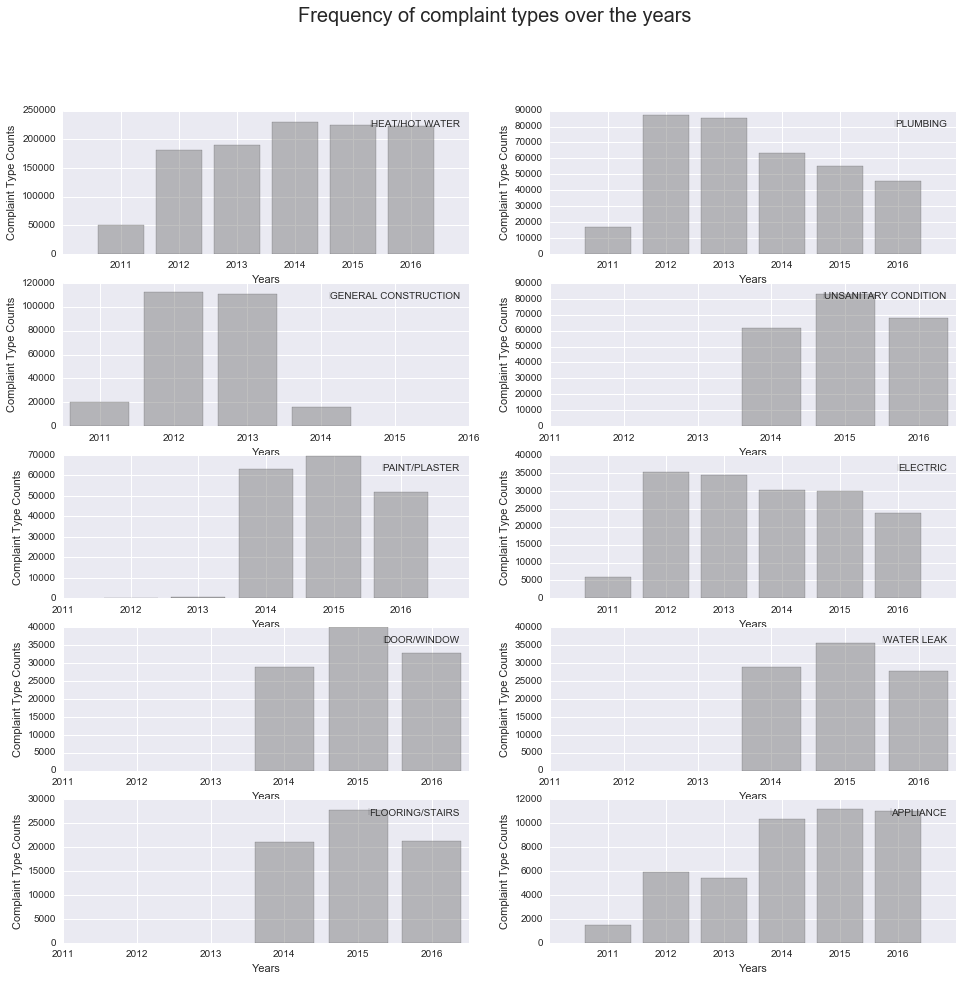

In [119]:
plt.figure(figsize = (16,18))
plt.suptitle('Frequency of complaint types over the years',fontsize=20)
for index,complaint_type in enumerate(house_complaint_types):
    # Create a matrix of subplots with 6 rows and two columns
    plt.subplot(5,2,index+1)
     
    # Create a sub-df for each category
    temp_df = df[df['Complaint Type']==complaint_type]
    
    # Drop column category from the new df to keep only year
    temp_df = temp_df.drop('Complaint Type', axis=1) # axis=1 means column
    
    # Drop 2017 as it could be misleading as only few values for the first two months exist
    temp_df = temp_df[temp_df['Created Year'] != 2017]
    
    # Count frequency of complaint type
    occurrencies = temp_df.groupby('Created Year')['Created Year'].count().reset_index(name='count').sort_values(by='Created Year', ascending=True)
    
    # Assign x and y values
    x = occurrencies['Created Year']
    y = occurrencies['count']

    plt.bar(x,y,align='center',alpha=.5, color='grey',label=complaint_type)
    plt.xticks(years[:-1],[str(year) for year in years[:-1]])
    plt.ylabel("Complaint Type Counts")
    plt.xlabel("Years")
    plt.legend(loc='upper right',frameon=False,handlelength=0, handletextpad=0)
    
# Show the barplot
plt.show()

From the above plots, we can already infer some interesting stats:
* **HEAT/HOT WATER** and **APPLIANCE** requests: there has been a strong increase from 2011 to 2012 in the frequency of complaints, and in general the frequency has kept quite steady and high during the last years;
* **PLUMBING** and **ELECTRIC** requests: in the latest years, it seems like the number has gradually decreased significantly (maybe a sign of a general improvement of the service?)

Concerning the other types, it doesn't look like there's a particular pattern in the frequency over the years...

### 2.2) Hourly Analysis
We noticed that by default 311 sets midnight as the time of the creation date of a complaint, when the exact time was unknown, probably. Therefore, if we included this entries the would be faked and not reasonable, therefore, for this specific purpose, we filter out these entries. 

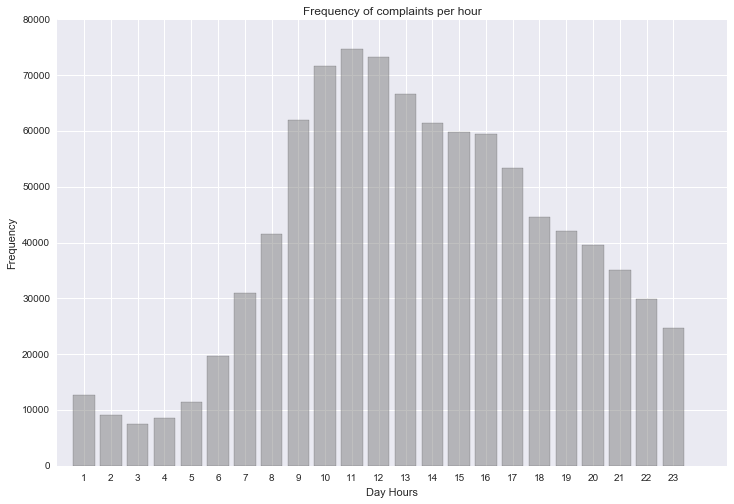

In [151]:
df['Hour']= df['Created Date'].apply(lambda x: getHour(x))

df_exclude_default = df[df['Hour']!=0]

# List the number of complaint types per year
complaint_frequency_hour = df_exclude_default.groupby('Hour')['Hour'].count().reset_index(name='count').sort_values(by='Hour', ascending=True)

# Assign x and y values
x = complaint_frequency_hour['Hour']
y = complaint_frequency_hour['count']

# Assign the size of the plot before declaring the plot
plt.figure(figsize= (12,8))

# Give the x and y values to the barplot
plt.bar(x, y, align = 'center', color='grey', alpha=.5)

# Give labels and titles
plt.ylabel("Frequency")
plt.title("Frequency of complaints per hour")
plt.xticks(range(1,24,1))
plt.xlabel("Day Hours")

# Show the barplot
plt.show()

The above plot clearly shows that the trend of frequency of complaint types is more than reasonable, with most of the complaints registered during the day hours.

If we now decompose this plot by extracting the same information for the considered complaint types, we might get even more info.

*Unfortunately, we have to filter out the `GENERAL CONSTRUCTION` complaint types because all its entries have a creation time at the default midnight*

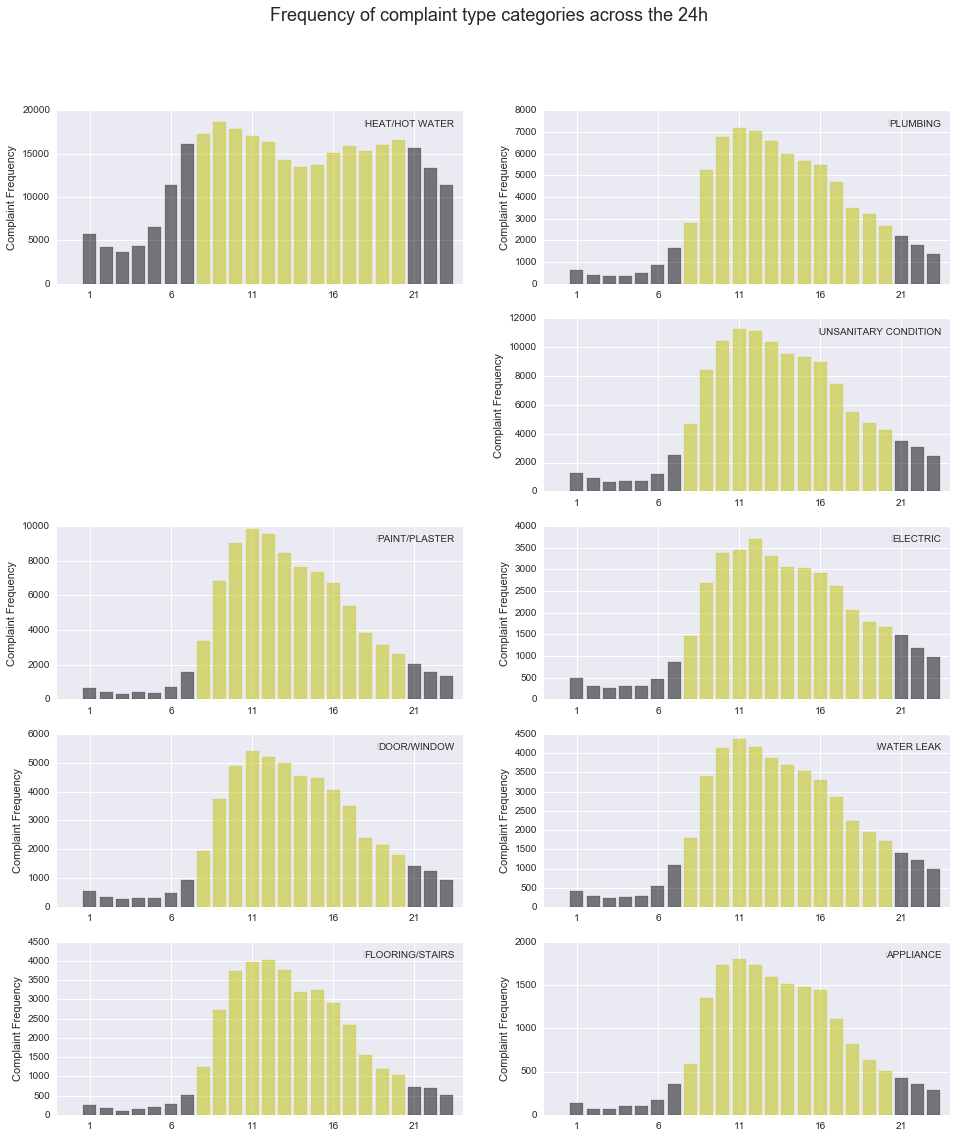

In [147]:
df_exclude_default = df_exclude_default[df_exclude_default['Complaint Type']!='GENERAL CONSTRUCTION']

plt.figure(figsize = (16,18))
plt.suptitle('Frequency of complaint type categories across the 24h',fontsize=18)
for index,complaint_type in enumerate(house_complaint_types):
    if complaint_type=='GENERAL CONSTRUCTION':
        continue
    # Create a matrix of subplots with 5 rows and two columns
    plt.subplot(5,2,index+1)
     
    # Create a sub-df for each category
    temp_df = df_exclude_default[df_exclude_default['Complaint Type']==complaint_type]
    
    # Drop column category from the new df to keep only hour
    temp_df = temp_df.drop('Complaint Type', axis=1) # axis=1 means column
    
    # Drop 2017 as it could be misleading as only few values for the first two months exist
    temp_df = temp_df[temp_df['Created Year'] != 2017]
    
    # Count frequency of complaint types
    occurrence = temp_df.groupby('Hour')['Hour'].count().reset_index(name='count').sort_values(by='Hour', ascending=1)
    
    # Assign x and y values
    x = occurrence['Hour']
    y = occurrence['count']

    bars = plt.bar(x,y,align='center',alpha=.5, color='grey',label=complaint_type)
    for i,bar in enumerate(bars):
        if (i>=0 and i<7) or i>=20:
            bar.set_color('k')
        else:
            bar.set_color('y')
        
    plt.xticks(np.arange(1,24,5))
    plt.ylabel("Complaint Frequency")
    plt.legend(loc='upper right',frameon=False,handlelength=0, handletextpad=0)
    plt.xlim(-1,24)
    
# Show the barplot
plt.show()

According to the above plot, we can clearly state pretty much all the complaint types follow the same trend:
* The frequency of requests significantly increases during the morning hours (between 7 and 11), by ending with a peak at 11/12.
* After 12, the frequency slightly decreases gradually until the evening hours.
* The only exception is represented by the **HEAT/HOT WATER** complaint types, that are pretty much frequent even during the evening, and their peak is moved to 9 AM!

### 2.3) Period of the year 
The analysis so far hasn't revealed any significant correlation between time of day and the frequency of the complaints. It might be interesting to instead try to see if there is a **correlation between period of the year and the frequency of complaints**:

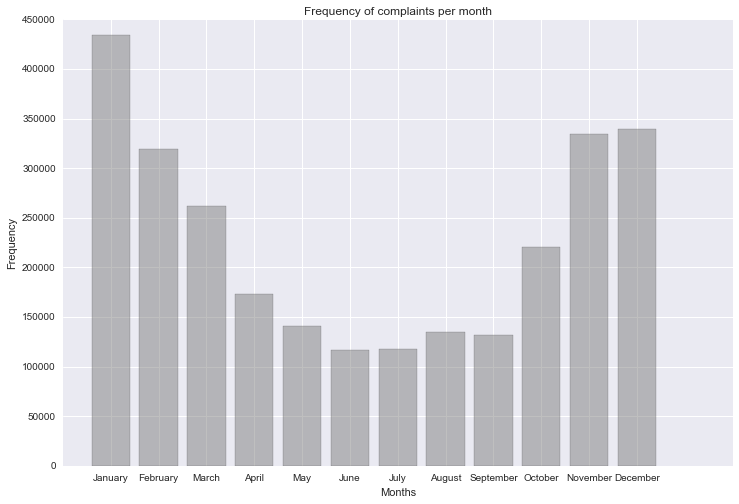

In [167]:
df['Month']= df['Created Date'].apply(lambda x: getMonth(x))

# List the number of complaint types per year
complaint_frequency_month = df.groupby('Month')['Month'].count().reset_index(name='count').sort_values(by='Month', ascending=True)

# Assign x and y values
x = complaint_frequency_month['Month']
y = complaint_frequency_month['count']

# Assign the size of the plot before declaring the plot
plt.figure(figsize= (12,8))

# Give the x and y values to the barplot
plt.bar(x, y, align = 'center', color='grey', alpha=.5)

# Give labels and titles
plt.ylabel("Frequency")
plt.title("Frequency of complaints per month")
months = ('January','February','March','April','May','June','July','August','September','October','November','December')
plt.xticks(range(1,13,1),months)
plt.xlabel("Months")

# Show the barplot
plt.show()

Ok, this reveals a definitely more interesting result: why is there so much difference in the frequency of complaints over the months of the year? Let's further investigate by considering the different categories of complaints:

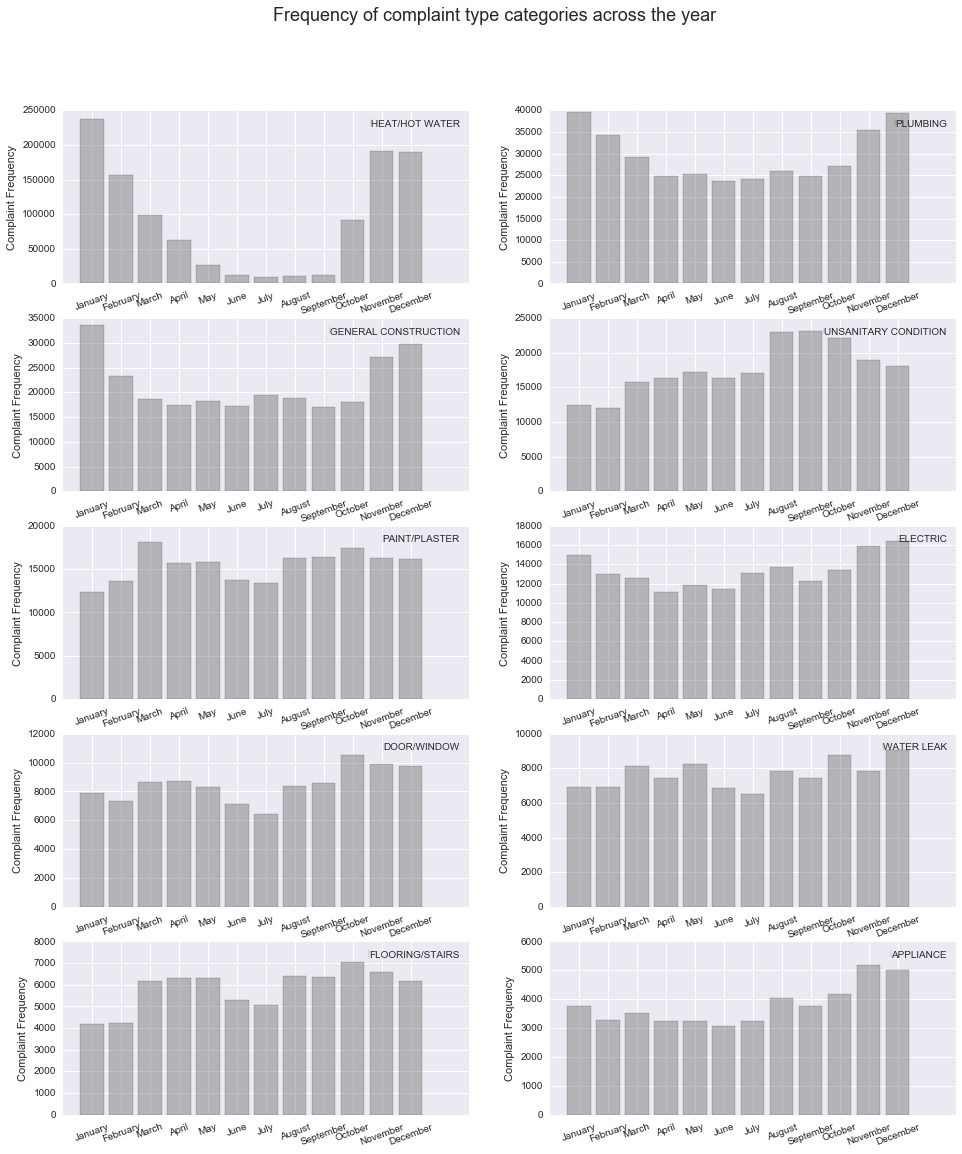

In [168]:
plt.figure(figsize = (16,18))
plt.suptitle('Frequency of complaint type categories across the year',fontsize=18)
for index,complaint_type in enumerate(house_complaint_types):
    # Create a matrix of subplots with 5 rows and two columns
    plt.subplot(5,2,index+1)
    
    # Create a sub-df for each category
    temp_df = df[df['Complaint Type']==complaint_type]
    
    # Drop column category from the new df to keep only hour
    temp_df = temp_df.drop('Complaint Type', axis=1) # axis=1 means column
    
    # Drop 2017 as it could be misleading as only few values for the first two months exist
    temp_df = temp_df[temp_df['Created Year'] != 2017]
    
    # Count frequency of complaint types
    occurrence = temp_df.groupby('Month')['Month'].count().reset_index(name='count').sort_values(by='Month', ascending=1)
    
    # Assign x and y values
    x = occurrence['Month']
    y = occurrence['count']

    bars = plt.bar(x,y,align='center',alpha=.5, color='grey',label=complaint_type)
    plt.xticks(np.arange(1,13),months,rotation='20')
    plt.ylabel("Complaint Frequency")
    plt.legend(loc='upper right',frameon=False,handlelength=0, handletextpad=0)
    
# Show the barplot
plt.show()

We can see somehow a pattern according to the different complaint type, therefore we might say we can consider the **period of the year** as a reasonable feature to use for machine learning classification tasks, by trying to predict the complaint type.

### 2.4) Call Duration
As a last attempt to identify relevant features for prediction models, let's see if there's any correlation between the average call duration and the type of complaint, and how did this improve over the years.

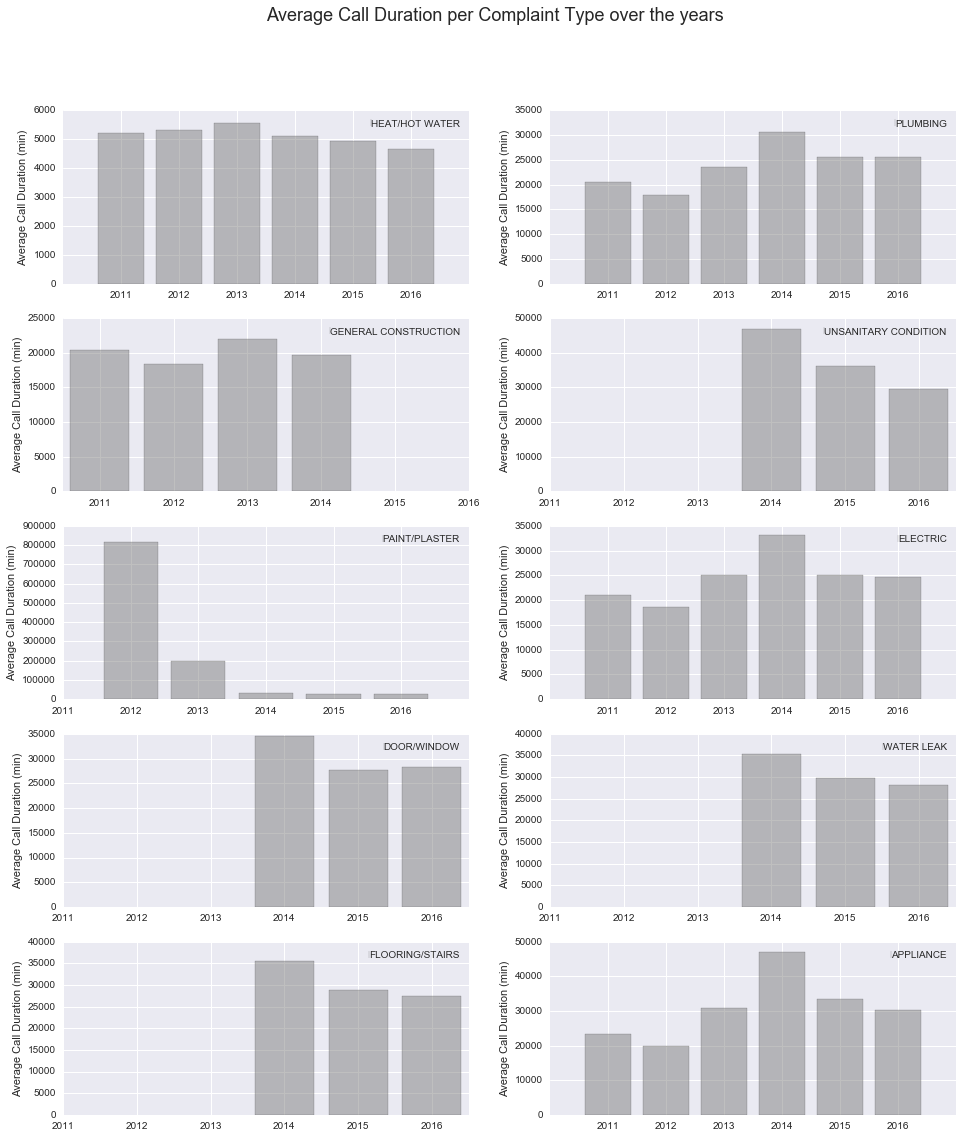

In [171]:
plt.figure(figsize = (16,18))
plt.suptitle('Average Call Duration per Complaint Type over the years',fontsize=18)
for index,complaint_type in enumerate(house_complaint_types):
    # Create a matrix of subplots with 5 rows and two columns
    plt.subplot(5,2,index+1)
    
    # Create a sub-df for each category
    temp_df = df[df['Complaint Type']==complaint_type]
    
    # Drop column category from the new df to keep only hour
    temp_df = temp_df.drop('Complaint Type', axis=1) # axis=1 means column
    
    # Drop 2017 as it could be misleading as only few values for the first two months exist
    temp_df = temp_df[temp_df['Created Year'] != 2017]
    
    # Calculate average of call duration per year
    occurrence = temp_df.groupby('Created Year')['Call Duration'].apply(lambda x:np.mean(x)).reset_index(name='mean').sort_values(by='Created Year', ascending=1)
    
    # Assign x and y values
    x = occurrence['Created Year']
    y = occurrence['mean']

    bars = plt.bar(x,y,align='center',alpha=.5, color='grey',label=complaint_type)
    plt.xticks(years[:-1],[str(year) for year in years[:-1]])
    plt.ylabel("Average Call Duration (min)")
    plt.legend(loc='upper right',frameon=False,handlelength=0, handletextpad=0)
    
# Show the barplot
plt.show()

According to the above results, it seems like that in general, 311 efficiency, measured by the average duration of the service requests per year, has improved over the last years, regardless the complaint type.

However, something that is worth pointint out, is that the scales of the plots are very different from each other, which makes it clear that there are strong differences between the different complaint types and the respective call duration. We can make it more evident by plotting the average call duration per complaint type:

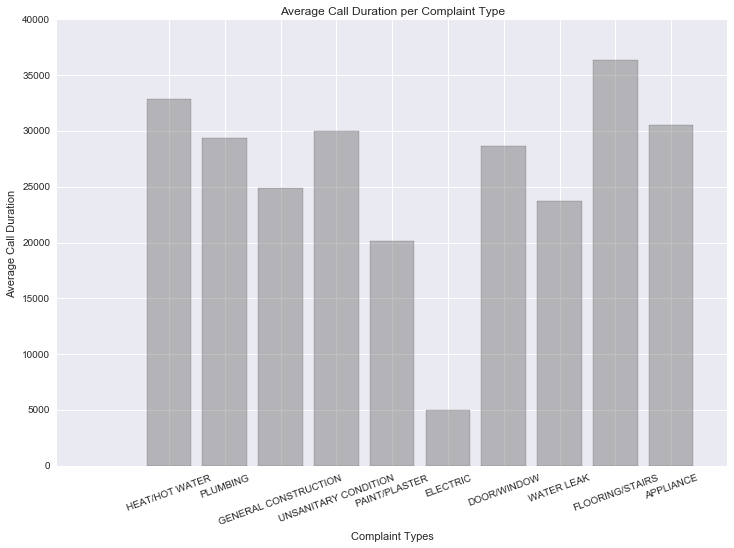

In [177]:
categories_average_call_duration = df.groupby('Complaint Type')['Call Duration'].apply(lambda x:np.mean(x)).reset_index(name='mean')

# Assign x and y values
x = range(len(house_complaint_types))
y = categories_average_call_duration['mean']

# Assign the size of the plot before declaring the plot
plt.figure(figsize= (12,8))

# Give the x and y values to the barplot
plt.bar(x, y, align = 'center', color='grey', alpha=.5)

# Give labels and titles
plt.ylabel("Average Call Duration")
plt.title("Average Call Duration per Complaint Type")
plt.xticks(range(len(house_complaint_types)),house_complaint_types,rotation='20')
plt.xlabel("Complaint Types")

# Show the barplot
plt.show()

At this point, we reached another conclusion:
* A first feature for the machine learning models will be the **period of the year (month)**;
* A second feature will be the **average call duration per complaint type**.

### 2.5) Complaint Type vs Neighborhood (Ratio)
What we're interested to complete our preliminary data exploration to identify relevant features and interesting trends, is to see if there are some boroughs where some specific complaints tend to happen more than what's typical.

First, we need to calculate the relative probabilities of seeing each type of complaint in the dataset as a whole. Let's call it `P(complaint)`.

In [211]:
# Create one more column with the relative probability of seeing each type of crime
call_freq['P(complaint)'] = call_freq['count']/call_freq['count'].sum()
call_freq.head()

,Complaint Type,count,P(complaint)
0,HEAT/HOT WATER,1185189,0.434698
1,PLUMBING,364728,0.133773
2,GENERAL CONSTRUCTION,258868,0.094946
3,UNSANITARY CONDITION,225624,0.082753
4,PAINT/PLASTER,197093,0.072289


We want to calculate that same probability distribution but for each **borough**, let's call that `P(complaint|borough)`. But we first need to calculate `P(borough)`:

In [212]:
borough_frequency = df['Borough'].groupby(df['Borough']).count().sort_values(ascending=False).reset_index(name='count')
borough_frequency['P(borough)']= borough_frequency['count']/borough_frequency['count'].sum()
borough_frequency

,Borough,count,P(borough)
0,BROOKLYN,913814,0.335164
1,BRONX,867044,0.318010
2,MANHATTAN,561708,0.206021
3,QUEENS,340321,0.124821
4,STATEN ISLAND,43579,0.015984


In [213]:
complaint_per_borough_freq = df.filter(items=['Complaint Type','Borough']).groupby(['Complaint Type','Borough']).size().reset_index(name="count")

The conditional probability `P(complaint|borough)` is given by: $P(complaint|borough)=P(complaint,borough)/P(borough)$ where the numerator is the probability that both events happen. Having from straight above the number of occurrencies of complaints related to a specific complaint type-borough pair, we can easily calculate that probability by simply dividing each count for the total number of counts (which is the total number of rows in the main dataframe):

In [214]:
complaint_per_borough_freq['P(complaint,borough)']=complaint_per_borough_freq['count']/complaint_per_borough_freq['count'].sum()
complaint_per_borough_freq.sort_values(by='P(complaint,borough)',ascending=False).head()

,Complaint Type,Borough,count,"P(complaint,borough)"
25,HEAT/HOT WATER,BRONX,389463,0.142845
26,HEAT/HOT WATER,BROOKLYN,362973,0.133129
27,HEAT/HOT WATER,MANHATTAN,270017,0.099036
28,HEAT/HOT WATER,QUEENS,151551,0.055585
36,PLUMBING,BROOKLYN,130300,0.047791


Finally, we can combine the previous results and obtain the desired conditional probability. It would be easier if we merge (join) the two dataframes, the `freq_borough_complaint` and the `call_freq_borough`, since the former has information about the combined probability and the latter about the probability of a complaint in a specific borough.

In [215]:
#We can get rid of the counts, we won't need them anymore for this combined table
#Only the probabilities are relevant
combined_df = pd.merge(complaint_per_borough_freq.filter(items=['Complaint Type','Borough','P(complaint,borough)']),
                              borough_frequency.filter(items=['Borough','P(borough)']),
                              on='Borough')
combined_df.head()

,Complaint Type,Borough,"P(complaint,borough)",P(borough)
0,APPLIANCE,BRONX,0.006025,0.31801
1,DOOR/WINDOW,BRONX,0.012692,0.31801
2,ELECTRIC,BRONX,0.016995,0.31801
3,FLOORING/STAIRS,BRONX,0.008656,0.31801
4,GENERAL CONSTRUCTION,BRONX,0.029632,0.31801


Now that we have all what we need in one table, let's just add the conditional probability as a new columnn:

In [216]:
combined_df['P(complaint|borough)'] = combined_df['P(complaint,borough)']/combined_df['P(borough)']
combined_df.sort_values(by='P(complaint,borough)',ascending=False).head()

,Complaint Type,Borough,"P(complaint,borough)",P(borough),P(complaint|borough)
5,HEAT/HOT WATER,BRONX,0.142845,0.318010,0.449185
15,HEAT/HOT WATER,BROOKLYN,0.133129,0.335164,0.397207
25,HEAT/HOT WATER,MANHATTAN,0.099036,0.206021,0.480707
35,HEAT/HOT WATER,QUEENS,0.055585,0.124821,0.445318
17,PLUMBING,BROOKLYN,0.047791,0.335164,0.142589


Now we look at the ratio `P(complaint|borough)/P(complaint)`. That ratio is equal to 1 if the crime occurs at the same level within a borough as in the city as a whole. If it's greater than one, it means that the crime occurs more frequently within that borough. If it's smaller than one, it means that the crime is rarer within the borough in question than in the city as a whole.

We just need to add the information about `P(complaint)`:

In [217]:
combined_df = pd.merge(combined_df,call_freq.filter(items=['Complaint Type','P(complaint)']),on='Complaint Type')
combined_df['Ratio'] = combined_df['P(complaint|borough)']/combined_df['P(complaint)']
combined_df.sort_values(by='Ratio',ascending=False).head()

,Complaint Type,Borough,"P(complaint,borough)",P(borough),P(complaint|borough),P(complaint),Ratio
44,UNSANITARY CONDITION,STATEN ISLAND,0.001987,0.015984,0.124326,0.082753,1.502369
14,ELECTRIC,STATEN ISLAND,0.001443,0.015984,0.090296,0.060623,1.489460
24,GENERAL CONSTRUCTION,STATEN ISLAND,0.002190,0.015984,0.137016,0.094946,1.443084
4,APPLIANCE,STATEN ISLAND,0.000382,0.015984,0.023888,0.017541,1.361788
39,PLUMBING,STATEN ISLAND,0.002815,0.015984,0.176140,0.133773,1.316706


We now show with some plots the ratios we just calculated, for each borough:

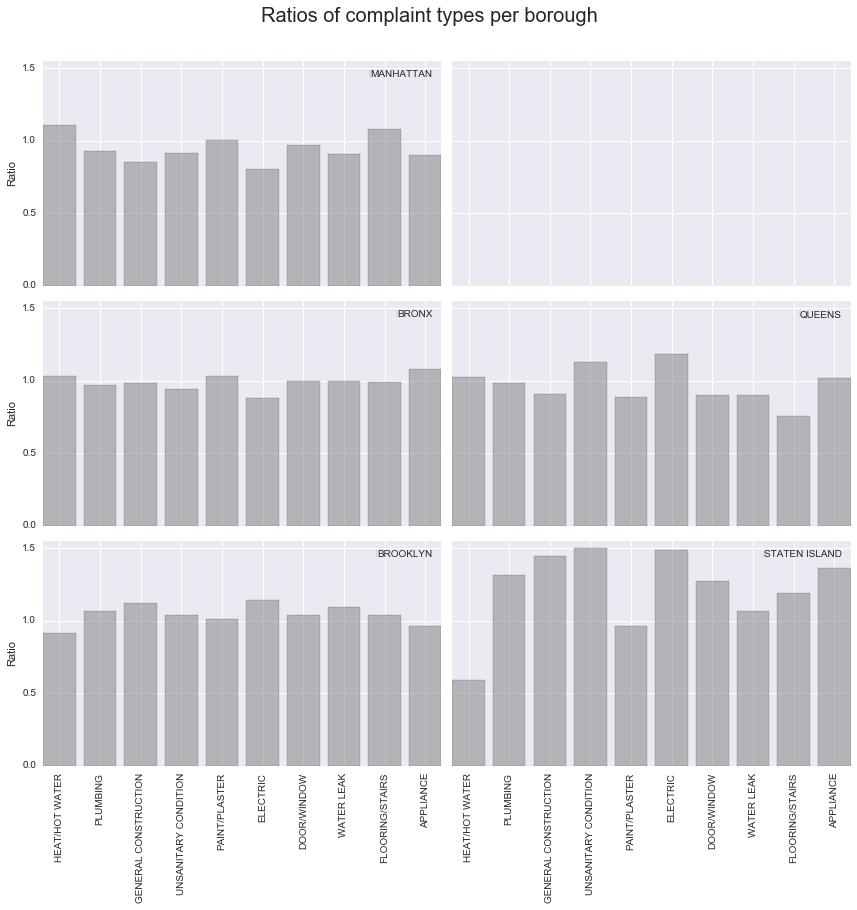

In [220]:
boroughs = list(df.Borough.unique())

# Assign variables to axes and figure
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(12, 12))

# Assign the size and the Super title
fig.suptitle('Ratios of complaint types per borough', fontsize=20, y=1.05)

for index,borough in enumerate(boroughs):
    # Create a sub-df for each category
    temp_df = combined_df[combined_df['Borough']==borough]
    
    # Drop columns to minimize the memory usage(optional)
    # axis=1 means column
    temp_df = temp_df.drop(['Borough','P(complaint)','P(complaint|borough)','P(complaint,borough)','P(borough)'], axis=1)
    
    # Assign x
    x = house_complaint_types
    # Give indeces to complaints
    x_pos = np.arange(len(x))
    
    # Assign y and keep the same sorting for each plot
    mapping = {complaint:i for i,complaint in enumerate(x)}
    key = temp_df['Complaint Type'].map(mapping)
    temp_df = temp_df.iloc[key.argsort()]
    y = temp_df['Ratio']
    
    # Assign x and y to subplots                   
    subindex = 0
    # Index < 3 means left column else right column
    if index < 3:
        # Create an ax object
        ax_temp =  ax[index][subindex]
        # Set Ratio label only in the left column
        ax_temp.set_ylabel("Ratio")
    else:
        # Create an ax object
        ax_temp =  ax[index-5][subindex+1]
    
    # Feed the ax object with the x and y values
    ax_temp.bar(x_pos,y,align='center',alpha=.5, color='grey',label=borough)
    ax_temp.legend(loc='upper right',frameon=False,handlelength=0, handletextpad=0)
    # Set the rotation to vertical
    for tick in ax_temp.get_xticklabels():
        tick.set_rotation(90)
    
    # Set xticks and yticks parameters
    plt.setp(ax, xticks=x_pos, xticklabels=x,yticks=np.arange(0,4.5,0.5))
    plt.ylim(0,1.55)
    
# Show the barplot
fig.tight_layout()
plt.show()

BUT THE LAST POINT 2.5) SHOULD BE CHANGED BY USING DISTRICTS CORRECTLY AND NOT BOROUGHS, otherwise the analysis is too general!

## 3) Machine Learning Tasks